In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. ML Mindset & Problem Framing
- We want to estimate the price of a ride based on trip and contextual factors.
- Due to traffic changes trip cost, demand fluctuates, weather affects ride duration, different cities behave differently, weekend patterns change pricing ML better than fixed rules.
Instead of manually writing complicated pricing rules.
- The model should learn: how distance affects price, how duration affects cost, how traffic increases price, how demand causes surge pricing and how contextual factors combine.

# 2. Data Exploration & Understanding
- ride_price (continuous) is what we want to predict
- Input Features (8 Features)
| Feature       | Type         | Why It Was Chosen           | How It Influences Price       |
| ------------- | ------------ | --------------------------- | ----------------------------- |
| distance_km   | Numerical    | Core cost driver            | Longer distance → higher cost |
| duration_min  | Numerical    | Time cost factor            | More time → higher cost       |
| traffic_level | Categorical  | Affects duration & cost     | High traffic → multiplier     |
| demand_level  | Categorical  | Surge pricing factor        | High demand → higher price    |
| weather       | Categorical  | Impacts demand & traffic    | Rain → higher cost            |
| time_of_day   | Categorical  | Peak vs off-peak            | Evening → higher demand       |
| city          | Categorical  | Regional pricing difference | Addis may cost more           |
| is_weekend    | Binary (0/1) | Demand pattern change       | Weekend → slight increase     |


- Base Fare: between 100–130 ETB
- Per km: 16 ETB
- Per min: 3 ETB

## Loading the data

In [2]:
df = pd.read_excel("rides.xlsx")

In [3]:
df.head()

,distance_km,duration_min,traffic_level,demand_level,weather,time_of_day,city,is_weekend,ride_price
0,5.2,15,Medium,Low,Clear,Morning,Addis Ababa,0,219.45
1,12.5,30,High,Medium,Rain,Evening,Addis Ababa,1,900.12
2,3.1,10,Low,Low,Clear,Afternoon,Hawassa,0,176.40
3,20.0,55,High,High,Rain,Night,Addis Ababa,1,1532.28
4,8.5,25,Medium,Medium,Clear,Morning,Adama,0,406.05


## Inspect the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance_km    150 non-null    float64
 1   duration_min   150 non-null    int64  
 2   traffic_level  150 non-null    object 
 3   demand_level   150 non-null    object 
 4   weather        150 non-null    object 
 5   time_of_day    150 non-null    object 
 6   city           150 non-null    object 
 7   is_weekend     150 non-null    int64  
 8   ride_price     150 non-null    float64
dtypes: float64(2), int64(2), object(5)
memory usage: 10.7+ KB


In [5]:
df.describe()

,distance_km,duration_min,is_weekend,ride_price
count,150.000000,150.000000,150.000000,150.000000
mean,10.322667,29.173333,0.446667,653.054000
std,5.198427,14.052035,0.498813,431.969659
min,2.500000,8.000000,0.000000,160.800000
25%,6.000000,18.000000,0.000000,237.960000
50%,8.500000,25.000000,0.000000,489.360000
75%,14.500000,41.500000,1.000000,975.120000
max,21.000000,55.000000,1.000000,1558.200000


In [6]:
df.isnull().sum()

distance_km      0
duration_min     0
traffic_level    0
demand_level     0
weather          0
time_of_day      0
city             0
is_weekend       0
ride_price       0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(20)

## Checking categorical values

In [8]:
print("Traffic levels:", df['traffic_level'].unique())
print("Demand levels:", df['demand_level'].unique())
print("Weather:", df['weather'].unique())
print("Time of day:", df['time_of_day'].unique())
print("City:", df['city'].unique())
print("Is weekend:", df['is_weekend'].unique())

Traffic levels: ['Medium' 'High' 'Low']
Demand levels: ['Low' 'Medium' 'High']
Weather: ['Clear' 'Rain']
Time of day: ['Morning' 'Evening' 'Afternoon' 'Night']
City: ['Addis Ababa' 'Hawassa' 'Adama' 'Bahir Dar']
Is weekend: [0 1]


## Visualizing the raw data

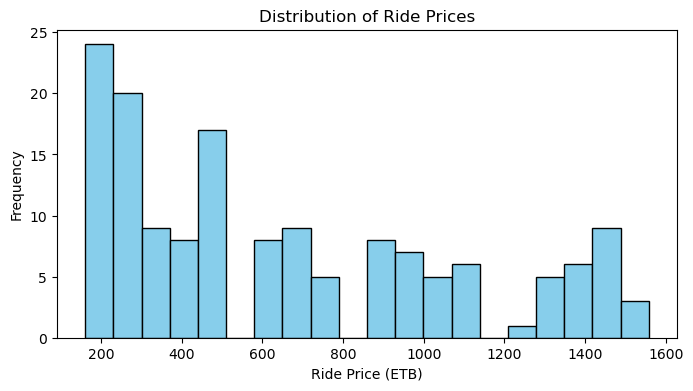

In [10]:
plt.figure(figsize=(8,4))
plt.hist(df['ride_price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ride Prices')
plt.xlabel('Ride Price (ETB)')
plt.ylabel('Frequency')
plt.show()

### Ride Price vs Traffic Level

C:\Users\JOKA TRADING\AppData\Local\Temp\ipykernel_12996\1329037438.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=traffic_levels)


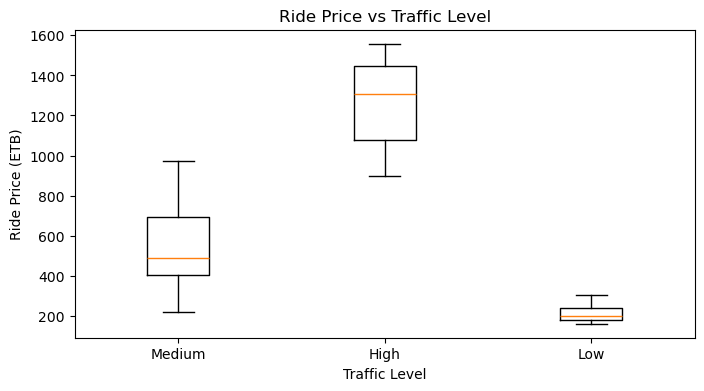

In [11]:
traffic_levels = df['traffic_level'].unique()
data_to_plot = [df[df['traffic_level'] == level]['ride_price'] for level in traffic_levels]

plt.figure(figsize=(8,4))
plt.boxplot(data_to_plot, labels=traffic_levels)
plt.title('Ride Price vs Traffic Level')
plt.xlabel('Traffic Level')
plt.ylabel('Ride Price (ETB)')
plt.show()

### Ride Price vs Demand Level

C:\Users\JOKA TRADING\AppData\Local\Temp\ipykernel_12996\3689066385.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=demand_levels)


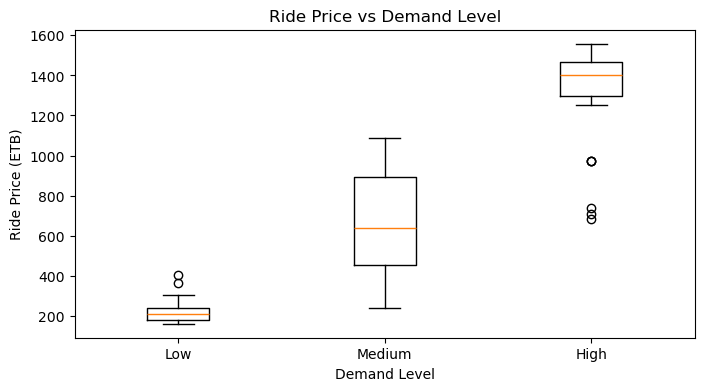

In [12]:
demand_levels = df['demand_level'].unique()
data_to_plot = [df[df['demand_level'] == level]['ride_price'] for level in demand_levels]
plt.figure(figsize=(8,4))
plt.boxplot(data_to_plot, labels=demand_levels)
plt.title('Ride Price vs Demand Level')
plt.xlabel('Demand Level')
plt.ylabel('Ride Price (ETB)')
plt.show()

### Ride Price vs Weather Condition

C:\Users\JOKA TRADING\AppData\Local\Temp\ipykernel_12996\1471039203.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=weather_types)


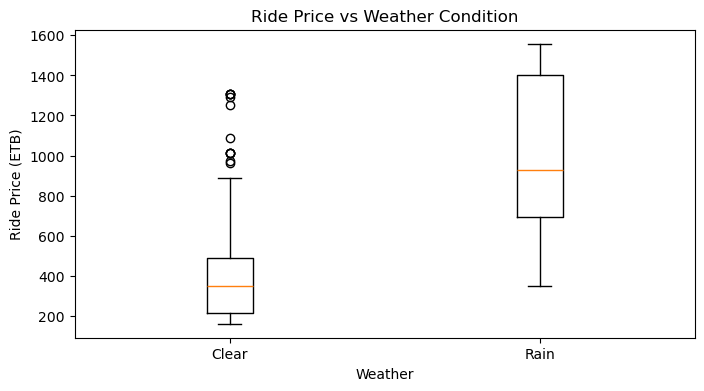

In [13]:
weather_types = df['weather'].unique()
data_to_plot = [df[df['weather'] == w]['ride_price'] for w in weather_types]

plt.figure(figsize=(8,4))
plt.boxplot(data_to_plot, labels=weather_types)
plt.title('Ride Price vs Weather Condition')
plt.xlabel('Weather')
plt.ylabel('Ride Price (ETB)')
plt.show()


### Ride Price vs City

C:\Users\JOKA TRADING\AppData\Local\Temp\ipykernel_12996\3880505203.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=cities)


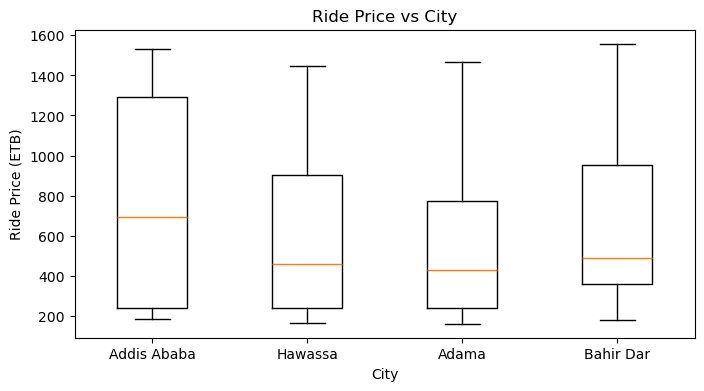

In [14]:
cities = df['city'].unique()
data_to_plot = [df[df['city'] == c]['ride_price'] for c in cities]

plt.figure(figsize=(8,4))
plt.boxplot(data_to_plot, labels=cities)
plt.title('Ride Price vs City')
plt.xlabel('City')
plt.ylabel('Ride Price (ETB)')
plt.show()


## Detecting Outliers

In [15]:
numeric_cols = ['distance_km', 'duration_min', 'ride_price']
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col} has {len(outliers)} outliers")

distance_km has 0 outliers
duration_min has 0 outliers
ride_price has 0 outliers


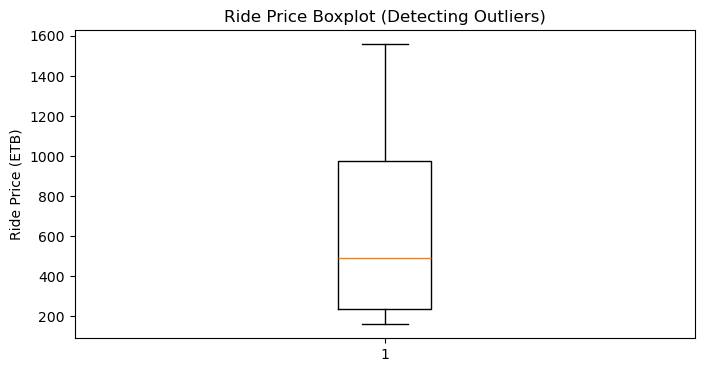

In [16]:
plt.figure(figsize=(8,4))
plt.boxplot(df['ride_price'])
plt.title('Ride Price Boxplot (Detecting Outliers)')
plt.ylabel('Ride Price (ETB)')
plt.show()

# 2. Data Cleaning & Feature Engineering

In [44]:
print(df.isnull().sum())
numeric_cols = ['distance_km', 'duration_min']
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

categorical_cols = ['traffic_level', 'demand_level', 'weather', 'time_of_day', 'city', 'is_weekend']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

distance_km      0
duration_min     0
traffic_level    0
demand_level     0
weather          0
time_of_day      0
city             0
is_weekend       0
ride_price       0
base_fare        0
high_cost        0
dtype: int64


C:\Users\JOKA TRADING\AppData\Local\Temp\ipykernel_12996\1371201189.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\JOKA TRADING\AppData\Local\Temp\ipykernel_12996\1371201189.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

## Encode Categorical Variables

In [18]:
df['traffic_level'] = df['traffic_level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['demand_level'] = df['demand_level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['weather'] = df['weather'].map({'Clear': 0, 'Rain': 1})
df['time_of_day'] = df['time_of_day'].map({'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3})
df['city'] = df['city'].map({'Addis Ababa': 0, 'Adama': 1, 'Hawassa': 2, 'Bahir Dar': 3})

## Detect & Treat Outliers

In [19]:
for col in ['distance_km', 'duration_min', 'ride_price']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

## Scale Numerical Features

In [20]:
for col in ['distance_km', 'duration_min']:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

## Feature Engineering

In [23]:
np.random.seed(42)
df['base_fare'] = np.random.randint(100, 131, size=len(df))

In [24]:
print(df.head())
print(df.info())
print(df.describe())

   distance_km  duration_min  traffic_level  demand_level  weather  \
0    -0.985426     -1.008632              1             0        0   
1     0.418845      0.058829              2             1        1   
2    -1.389395     -1.364452              0             0        0   
3     1.861589      1.837931              2             2        1   
4    -0.350619     -0.296991              1             1        0   

   time_of_day  city  is_weekend  ride_price  base_fare  
0            0     0           0      219.45        106  
1            2     0           1      900.12        119  
2            1     2           0      176.40        128  
3            3     0           1     1532.28        114  
4            0     1           0      406.05        110  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance_km    150 non-null    fl

# 3. Regression Model: Price Prediction

## Preparing Features and Target

In [26]:
X = df.drop('ride_price', axis=1)
y = df['ride_price']

## Spliting Data into Training and Testing Sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training Linear Regression Model

In [28]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Predict Ride Prices

In [29]:
y_pred = lr_model.predict(X_test)

## Evaluating the Model

In [30]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 5811.55
R² Score: 0.96


## Visulatizing(Predicted vs Actual Prices)

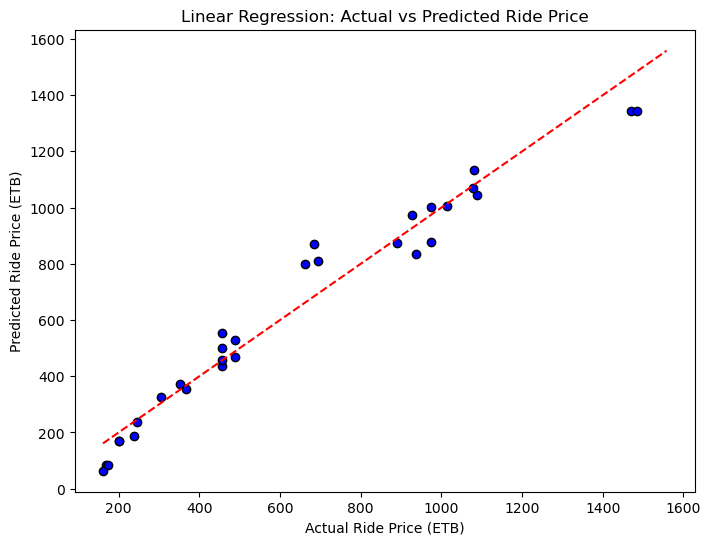

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Ride Price (ETB)')
plt.ylabel('Predicted Ride Price (ETB)')
plt.title('Linear Regression: Actual vs Predicted Ride Price')
plt.show()

# 5. Classification Model: High-Cost vs Low-Cost Ride

## Creating a Binary Target

In [38]:
df['high_cost'] = df['ride_price'].apply(lambda x: 1 if x > 700 else 0)
print(df['high_cost'].value_counts())

high_cost
0    94
1    56
Name: count, dtype: int64


## Preparing Features and Target

In [33]:
X_class = df.drop(['ride_price', 'high_cost'], axis=1)
y_class = df['high_cost']

## Spliting Data into Training and Testing Sets

In [35]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

## Training Logistic Regression Model

In [45]:
log_model = LogisticRegression()
log_model.fit(X_train_class, y_train_class)

C:\Users\JOKA TRADING\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Making Predictions

In [39]:
y_pred_class = log_model.predict(X_test_class)
y_prob_class = log_model.predict_proba(X_test_class)[:, 1]

## Evaluate the Model

In [41]:
acc = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy: {acc:.2f}")
cm = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.97
Confusion Matrix:
[[18  1]
 [ 0 11]]


- Probabilities (y_prob_class) show how confident the model is for each ride.

# 6. Model Evaluation & Comparison

- High R² → model explains most of the variance.
- MSE shows average squared error in birr gives practical sense of prediction accuracy.
- Linear Regression predicted continuous ride prices (ride_price)

In [42]:
print(f"Mean Squared Error (Regression): {mse:.2f}")
print(f"R² Score (Regression): {r2:.2f}")

Mean Squared Error (Regression): 5811.55
R² Score (Regression): 0.96


- Logistic Regression predicted high-cost vs low-cost rides.
- Accuracy tells % of rides correctly classified.
- Confusion matrix shows mistakes: false positives (low-cost predicted as high-cost) or false negatives (high-cost predicted as low-cost).

## Feature Influence
- Distance (distance_km): longer rides cost more = very influential
- Duration (duration_min): longer trips slightly increase price= important
- Traffic Level: more traffic increases fare= moderately influential
- Demand Level: peak demand increases fare= important
- Weather: rainy conditions slightly raise fare= minor influence
- City: local differences in fare structure= moderate

# 7. Ethical & Practical Reflection
## Potential Unfair Pricing Behavior
Even with a well-designed model, there can be unfairness in pricing:
Example:
- High surge pricing during peak demand or bad weather could disadvantage low-income riders.
- Certain neighborhoods (e.g., outskirts vs city center) might consistently get higher fares, creating geo-based bias.
## Real-World Risks of Deploying the Model
- Incorrect predictions: A regression model might underestimate a ride price, leading to revenue loss for the company And overestimation could discourage riders.
- Model reliance on synthetic data: This model is trained on synthetic Ethiopian data, so real-world rides may differ.
- Surge pricing risk: If logistic regression misclassifies “high-cost” rides, drivers might game the system or riders may lose trust.
## Limitations of the Dataset
- Synthetic dataset: 150 rows only : small for generalization and random base fares and randomly assigned features may not perfectly reflect actual Ethiopian ride patterns
- Feature limitations: We didn’t include exact pickup/dropoff locations or ride type (e.g., taxi, minibus), which could affect price. And real traffic data or weather severity is simplified.
- No real-time dynamics: Demand, traffic, and weather were manually assigned → real-world fluctuations not captured

In [43]:
print(f"Accuracy (Classification): {acc:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy (Classification): 0.97
Confusion Matrix:
[[18  1]
 [ 0 11]]
